 # Prediction
 Keras on Tensorflow
 
 This prediction runs on all 9 dataset. 

In [1]:
import os, sys
import cv2
import numpy as np
import uuid
import tensorflow as tf
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from imutils import paths
import itertools
import json
from pprint import pprint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from core.models import vanilla_unet, vanilla_unet_nodrop, UNet
from core.metrics import iou_coef, dice_coef


from tensorflow.keras.models import load_model
from datetime import datetime

from core.imageprep import create_crop_idx, crop_to_patch, construct_from_patch, create_crop_idx_whole
from core.train_predict import stack_predict, stack_predict_v2
from tqdm.notebook import trange

from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('load_ext', 'tensorboard')

In [2]:
from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


 ## Load Training Dataset

In [3]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')

# experiment
exp_name = 'dl_seg_project_raw'

# label
label = 'lipid_droplets'

# trianing timestamp
training_date = '2019_12_06'
imginput_timestamp = '2019_12_06_17_06'
# model_training_timestamp = '2019_12_11_12_21'
model_training_timestamp = '2019_12_06_17_26'
run_number = 'run-2'
print('Training timestamp: {}'.format(model_training_timestamp))

# input img path
imginput = os.path.join(exp_name, 'data_crop', imginput_timestamp)
imgpath = os.path.join(path, imginput)
print('Input Images Path: {}'.format(imgpath))

# model path
modelfd = 'model'
modelfn = 'model_' + model_training_timestamp + '.h5'
path_model = os.path.join(path, 'logs', modelfd, label, training_date, modelfn)
#path_model = os.path.join(path, 'logs', 'fit', label, training_date, model_training_timestamp, run_number, modelfd, modelfn)
print('Model Path: {}'.format(path_model))

# raw path
rawfd = 'raw_input_image'
path_raw = os.path.join(path, rawfd)
print('Raw Path: {}'.format(path_raw))

# prediction path
pred_path = os.path.join(path, exp_name)
dir_checker('pred_img', pred_path)

Load Images...
Training timestamp: 2019_12_06_17_26
Input Images Path: D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_06_17_06
Model Path: D:PerlmutterData\logs\model\lipid_droplets\2019_12_06\model_2019_12_06_17_26.h5
Raw Path: D:PerlmutterData\raw_input_image
pred_img exists in D:PerlmutterData\dl_seg_project_raw


## Parameter

In [4]:
# load parameter
parsfd = 'pars'
parsfn = 'pars_' + model_training_timestamp + '.json'
path_pars = os.path.join(path, 'logs', parsfd, label, training_date, parsfn)

with open(path_pars) as json_file:
    pars = json.load(json_file)

In [5]:
pprint(pars)

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 16,
 'classes': ['cell_membrane', 'nucleus', 'autophagosome'],
 'data_gen_img_args': {'height_shift_range': 0.1,
                       'horizontal_flip': True,
                       'rescale': 0.00392156862745098,
                       'rotation_range': 90.0,
                       'shear_range': 0.07,
                       'validation_split': 0.1,
                       'vertical_flip': True,
                       'width_shift_range': 0.1,
                       'zoom_range': 0.2},
 'data_gen_label_args': {'height_shift_range': 0.1,
                         'horizontal_flip': True,
                         'rescale': 0.00392156862745098,
                         'rotation_range': 90.0,
                         'shear_range': 0.07,
                         'validation_split': 0.1,
                         'vertical_flip': True,
                         'width_shift_range': 0.1,
                         'zoom_range': 0.2},
 'epo

In [6]:
IMG_HEIGHT = pars['IMG_HEIGHT']
IMG_WIDTH = pars['IMG_WIDTH']

IMG_HEIGHT = 256
IMG_WIDTH = 256

## Predict from Testing Dataset

In [8]:
# get dataset
rawfdlist = os.listdir(path_raw)
# rawfdlist = [rawfdlist[6]]
rawfdlist = list(rawfdlist[i] for i in [3, 5, 6])
print(rawfdlist)

['data_d07_batch01_loc01', 'data_d07_batch02_loc02', 'data_d14_batch01_loc01']


In [9]:
rawimglist = {}
for folder in rawfdlist:
    print(folder)
    rawimglist[folder] = list(paths.list_images(os.path.join(path_raw, folder, 'image')))

data_d07_batch01_loc01
data_d07_batch02_loc02
data_d14_batch01_loc01


In [10]:
pprint(rawimglist)

{'data_d07_batch01_loc01': ['D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0000.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0001.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0002.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0003.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0004.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0005.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0006.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0007.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_000

                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0550.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0551.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0552.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0553.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0554.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0555.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0556.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_0557.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch02_loc02\\image\\image_055

                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_0246_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_0247_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_0248_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_0249_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_0250_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_0251_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_0252_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_bat

                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_2008_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_2009_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_2010_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_2011_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_2012_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_2013_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_batch01_loc01\\image\\TH-4891-14dayDOX-C-H16_2014_IC.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d14_bat

## Define Prediction Set 

In [11]:
samplesize = 30
rawimglist_small = {}
for idx, item in rawimglist.items():
    img_count_tmp = len(rawimglist[idx])
    start = int(img_count_tmp * 2/3)
    rawimglist_small[idx] = rawimglist[idx][start:(start + samplesize)]
pprint(rawimglist_small)

{'data_d07_batch01_loc01': ['D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0792.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0793.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0794.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0795.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0796.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0797.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0798.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_0799.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d07_batch01_loc01\\image\\image_080

In [12]:
# print(rawimglist_small['data_d00_batch02_loc03'])

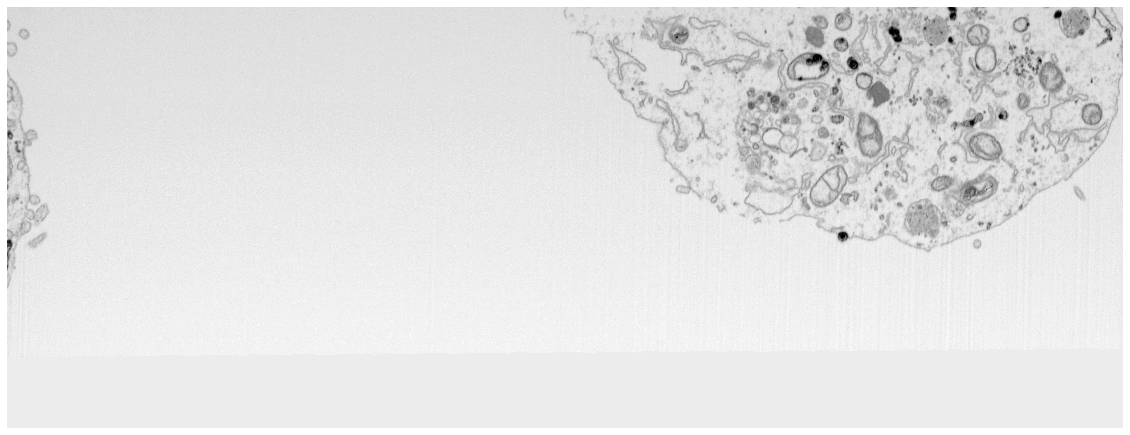

In [13]:
img = imread(rawimglist[rawfdlist[0]][0])
plt.figure(figsize = (20,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [14]:
'''
model = load_model(path_model, custom_objects={'iou_coef': iou_coef, 'dice_coef': dice_coef})
print(model)
model.summary()
'''

"\nmodel = load_model(path_model, custom_objects={'iou_coef': iou_coef, 'dice_coef': dice_coef})\nprint(model)\nmodel.summary()\n"

In [15]:
learning_rate = 1e-5
loss = "binary_crossentropy"
metrics = ['accuracy', iou_coef, dice_coef]

model = UNet(shape = (None, None), 
             lr = learning_rate, 
             loss = loss,
             metrics = metrics,)

model.load_weights(path_model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [16]:
opdir = os.path.join(pred_path, 'pred_img')
fdnm_small = 'batch_small_fullsize' + '_' + model_training_timestamp + '_' + run_number

def checkpredfolder(rawfdlist, opdir, opfolder, label):
    # folder name
    dir_checker(label, opdir)
    img_path_small = os.path.join(opdir, label)
    dir_checker(opfolder, img_path_small)

    # create folder list
    for folder in rawfdlist:
        dir_checker(folder, os.path.join(img_path_small, opfolder))

checkpredfolder(rawfdlist, opdir, fdnm_small, label)


lipid_droplets exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_small_fullsize_2019_12_06_17_26_run-2 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets
data_d07_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small_fullsize_2019_12_06_17_26_run-2
data_d07_batch02_loc02 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small_fullsize_2019_12_06_17_26_run-2
data_d14_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_small_fullsize_2019_12_06_17_26_run-2


In [17]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    
    folder = rawfdlist[idx]
    
    print(folder)
    
    pred_input_imgs =  rawimglist_small[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_small, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)

data_d07_batch01_loc01
[[   0  256 1982 2238    0    9]
 [ 230  486 1982 2238    1    9]
 [ 460  716 1982 2238    2    9]
 [ 588  844    0  256    3    0]
 [ 588  844  230  486    3    1]
 [ 588  844  460  716    3    2]
 [ 588  844  690  946    3    3]
 [ 588  844  920 1176    3    4]
 [ 588  844 1150 1406    3    5]
 [ 588  844 1380 1636    3    6]
 [ 588  844 1610 1866    3    7]
 [ 588  844 1840 2096    3    8]
 [ 588  844 1982 2238    3    9]]


C:\Users\wucci_admin\Documents\code\dl_fibem_seg\core\imageprep.py:558: RuntimeWarning: Mean of empty slice
  outputimg = np.nanmean(img_stack_repos, axis = 0)



data_d07_batch02_loc02
[[   0  256 2093 2349    0   10]
 [ 230  486 2093 2349    1   10]
 [ 460  716 2093 2349    2   10]
 [ 473  729    0  256    3    0]
 [ 473  729  230  486    3    1]
 [ 473  729  460  716    3    2]
 [ 473  729  690  946    3    3]
 [ 473  729  920 1176    3    4]
 [ 473  729 1150 1406    3    5]
 [ 473  729 1380 1636    3    6]
 [ 473  729 1610 1866    3    7]
 [ 473  729 1840 2096    3    8]
 [ 473  729 2070 2326    3    9]
 [ 473  729 2093 2349    3   10]]



data_d14_batch01_loc01
[[   0  256 1960 2216    0    9]
 [ 230  486 1960 2216    1    9]
 [ 460  716 1960 2216    2    9]
 [ 682  938    0  256    3    0]
 [ 682  938  230  486    3    1]
 [ 682  938  460  716    3    2]
 [ 682  938  690  946    3    3]
 [ 682  938  920 1176    3    4]
 [ 682  938 1150 1406    3    5]
 [ 682  938 1380 1636    3    6]
 [ 682  938 1610 1866    3    7]
 [ 682  938 1840 2096    3    8]
 [ 682  938 1960 2216    3    9]]


## Prediction Small Dataset with tiles
### Create Folder 

## Prediction Small Dataset with tiles (whole stack)
### Create Folder 

In [18]:
# folder name
fdnm_total = 'batch_total_fullsize' + '_' + model_training_timestamp + '_' + run_number
checkpredfolder(rawfdlist, opdir, fdnm_total, label)

lipid_droplets exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_total_fullsize_2019_12_06_17_26_run-2 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets
data_d07_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total_fullsize_2019_12_06_17_26_run-2
data_d07_batch02_loc02 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total_fullsize_2019_12_06_17_26_run-2
data_d14_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\lipid_droplets\batch_total_fullsize_2019_12_06_17_26_run-2


### Tiling Prediction with Stack Input
- Crop image into patched by a given overlap factor
- Export a cropping index
- Construct patches back into a image 

In [19]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_total, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)


[[   0  256 1982 2238    0    9]
 [ 230  486 1982 2238    1    9]
 [ 460  716 1982 2238    2    9]
 [ 588  844    0  256    3    0]
 [ 588  844  230  486    3    1]
 [ 588  844  460  716    3    2]
 [ 588  844  690  946    3    3]
 [ 588  844  920 1176    3    4]
 [ 588  844 1150 1406    3    5]
 [ 588  844 1380 1636    3    6]
 [ 588  844 1610 1866    3    7]
 [ 588  844 1840 2096    3    8]
 [ 588  844 1982 2238    3    9]]


C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)



[[   0  256 2093 2349    0   10]
 [ 230  486 2093 2349    1   10]
 [ 460  716 2093 2349    2   10]
 [ 473  729    0  256    3    0]
 [ 473  729  230  486    3    1]
 [ 473  729  460  716    3    2]
 [ 473  729  690  946    3    3]
 [ 473  729  920 1176    3    4]
 [ 473  729 1150 1406    3    5]
 [ 473  729 1380 1636    3    6]
 [ 473  729 1610 1866    3    7]
 [ 473  729 1840 2096    3    8]
 [ 473  729 2070 2326    3    9]
 [ 473  729 2093 2349    3   10]]



[[   0  256 1960 2216    0    9]
 [ 230  486 1960 2216    1    9]
 [ 460  716 1960 2216    2    9]
 [ 682  938    0  256    3    0]
 [ 682  938  230  486    3    1]
 [ 682  938  460  716    3    2]
 [ 682  938  690  946    3    3]
 [ 682  938  920 1176    3    4]
 [ 682  938 1150 1406    3    5]
 [ 682  938 1380 1636    3    6]
 [ 682  938 1610 1866    3    7]
 [ 682  938 1840 2096    3    8]
 [ 682  938 1960 2216    3    9]]
